In [37]:
import argparse
import os
import pickle
import shutil

import sklearn.metrics as metrics
import torch

import models
import utils.io_utils as io_utils
import utils.parser_utils as parser_utils
from explainer import explain
import sys

In [38]:
import pickle
import torch
import models
import utils.io_utils as io_utils
import utils.parser_utils as parser_utils
from explainer import explain


# Step 1: Argument Parsing (based on your explainer_main.py setup)
def arg_parse():
    # Check if we are in a Jupyter notebook environment

    # Manually set the arguments for notebook usage
    class Args:
        dataset = "mutag0"
        bmname = "mutag0"
        pkl_fname = None
        logdir = "log"
        ckptdir = "ckpt"
        cuda = "0"
        gpu = False
        num_epochs = 1000
        hidden_dim = 20
        output_dim = 20
        num_gc_layers = 3
        dropout = 0.01
        mask_act = "sigmoid"
        explain_node = None
        graph_idx = -1
        graph_mode = True  # Graph classification mode
        align_steps = 1000
        opt = "adam"
        opt_scheduler = "none"
        method = "base"  # Method attribute was missing
        name_suffix = ""
        explainer_suffix = ""
        clip = 2.0
        lr = 0.1
        batch_size = 20
        bias = True
        clean_log = False
        bn = False
        mask_bias = False

    return Args()


# Step 2: Function to Initialize Explainer and Model
def initialize_explainer():
    # Load the arguments
    prog_args = arg_parse()

    if prog_args.gpu:
        os.environ["CUDA_VISIBLE_DEVICES"] = prog_args.cuda
        print("Using GPU")
    else:
        print("Using CPU")

    # Load a model checkpoint
    ckpt = io_utils.load_ckpt(prog_args)
    cg_dict = ckpt["cg"]  # get computation graph

    input_dim = cg_dict["feat"].shape[2]
    num_classes = cg_dict["pred"].shape[2]

    print("Loaded model from checkpoint")
    print("Input dim:", input_dim, "; Num classes:", num_classes)

    # Build the model
    if prog_args.graph_mode:
        model = models.GcnEncoderGraph(
            input_dim=input_dim,
            hidden_dim=prog_args.hidden_dim,
            embedding_dim=prog_args.output_dim,
            label_dim=num_classes,
            num_layers=prog_args.num_gc_layers,
            bn=prog_args.bn,
            args=prog_args,
        )
    else:
        model = models.GcnEncoderNode(
            input_dim=input_dim,
            hidden_dim=prog_args.hidden_dim,
            embedding_dim=prog_args.output_dim,
            label_dim=num_classes,
            num_layers=prog_args.num_gc_layers,
            bn=prog_args.bn,
            args=prog_args,
        )

    # Load the model state
    model.load_state_dict(ckpt["model_state"])

    # Initialize the explainer
    explainer = explain.Explainer(
        model=model,
        adj=cg_dict["adj"],
        feat=cg_dict["feat"],
        label=cg_dict["label"],
        pred=cg_dict["pred"],
        train_idx=cg_dict["train_idx"],
        args=prog_args,
        writer=None,  # No Tensorboard logging for simplicity
        print_training=True,
        graph_mode=prog_args.graph_mode,
        graph_idx=prog_args.graph_idx,
    )

    return explainer


# Step 3: Prototype Extraction Function
import torch
import numpy as np


# Function to extract prototype (non-masked nodes and features)
def extract_prototype(graph_idx, explainer):
    """
    Extract and save the prototype for a given graph.

    Args:
        graph_idx: Index of the graph to explain
        explainer: The explainer instance used to generate explanations

    Returns:
        prototype: A dictionary containing important nodes and their corresponding important features
    """
    print(f"Explaining graph {graph_idx}...")

    # Explain the graph and get the masked adjacency matrix
    masked_adj = explainer.explain(node_idx=0, graph_idx=graph_idx, graph_mode=True)

    # If masked_adj is a numpy array, convert it to a tensor
    if isinstance(masked_adj, np.ndarray):
        masked_adj = torch.tensor(masked_adj)

    # Get feature mask if available
    mask_feat = explainer.mask_feat if hasattr(explainer, "mask_feat") else None

    # Retain only the non-masked nodes (summing over axis 1 to get the importance of each node)
    node_importance = masked_adj.sum(dim=1)  # Sum over rows to get node importance
    important_nodes = torch.nonzero(
        node_importance > 0
    ).squeeze()  # Keep important nodes

    # Retain only non-masked features for important nodes
    important_features = explainer.feat[important_nodes]
    if mask_feat is not None:
        important_features = important_features * mask_feat[important_nodes]

    # Prepare the prototype data
    prototype = {
        "important_nodes": important_nodes.cpu().numpy(),
        "important_features": important_features.cpu().numpy(),
    }

    # Save the prototype to a file
    prototype_file = f"prototype_graph_{graph_idx}.pkl"
    with open(prototype_file, "wb") as f:
        pickle.dump(prototype, f)

    print(f"Prototype for graph {graph_idx} saved to {prototype_file}.")
    return prototype

    # Save the prototype to a file
    prototype_file = f"prototype_graph_{graph_idx}.pkl"
    with open(prototype_file, "wb") as f:
        pickle.dump(prototype, f)

    print(f"Prototype for graph {graph_idx} saved to {prototype_file}.")
    return prototype


# Initialize the explainer
explainer = initialize_explainer()

# Step 4: Generate prototypes for test graphs (replace with your test graph indices)
test_graph_indices = [0, 1, 2, 3]  # Example test graph indices

# Extract prototypes
for graph_idx in test_graph_indices:
    prototype = extract_prototype(graph_idx, explainer)
    print(prototype)
    print(f"Prototype for graph {graph_idx}: {prototype}")

Using CPU
loading model
ckpt/mutag0_base_h20_o20.pth.tar
=> loading checkpoint 'ckpt/mutag0_base_h20_o20.pth.tar'
Loaded model from checkpoint
Input dim: 14 ; Num classes: 2301
Explaining graph 0...
Graph predicted label:  0
epoch:  0 ; loss:  37.92865753173828 ; mask density:  0.721884548664093 ; pred:  tensor([7.2322e-01, 2.7247e-01, 2.4235e-06,  ..., 1.8473e-06, 2.0178e-06,
        1.8965e-06], grad_fn=<SoftmaxBackward0>)
epoch:  1 ; loss:  36.7010498046875 ; mask density:  0.711325466632843 ; pred:  tensor([9.1403e-01, 8.1619e-02, 2.4728e-06,  ..., 1.8918e-06, 2.1593e-06,
        1.9036e-06], grad_fn=<SoftmaxBackward0>)
epoch:  2 ; loss:  35.637001037597656 ; mask density:  0.6992865800857544 ; pred:  tensor([9.3692e-01, 5.8851e-02, 2.4323e-06,  ..., 1.8123e-06, 2.1699e-06,
        1.8132e-06], grad_fn=<SoftmaxBackward0>)
epoch:  3 ; loss:  34.54254913330078 ; mask density:  0.6861923933029175 ; pred:  tensor([9.4770e-01, 4.8155e-02, 2.4066e-06,  ..., 1.7497e-06, 2.1751e-06,
      

In [39]:
# from dataset import GraphDataset, create_dataset

# pyg_dataset = GraphDataset(
#     torch.load("my_data/cycle_line_star_complete_1.pt", weights_only=False)
# )

In [40]:
from torch_geometric.data import Data


import torch
from torch_geometric.data import Data
from torch_geometric.utils import dense_to_sparse


def reconstruct_dataset_from_ckpt(prog_args):
    # Use io_utils to load the checkpoint
    ckpt = io_utils.load_ckpt(prog_args)
    cg_dict = ckpt["cg"]  # Get computation graph data

    # Extract adjacency matrices, features, and labels
    adj = cg_dict["adj"]  # Adjacency matrices
    feat = cg_dict["feat"]  # Node features
    labels = cg_dict["label"]  # Labels

    dataset = []
    for i in range(len(adj)):
        # Convert adjacency matrix to edge_index format (from dense to sparse)
        adj_matrix = torch.tensor(adj[i])
        edge_index, edge_attr = dense_to_sparse(adj_matrix)  # Convert to edge_index

        # Get node features and labels
        node_features = torch.tensor(feat[i])
        graph_label = torch.tensor(labels[i])

        # Create PyTorch Geometric Data object
        data = Data(x=node_features, edge_index=edge_index, y=graph_label)

        dataset.append(data)

    return dataset


prog_args = arg_parse()
pyg_dataset = reconstruct_dataset_from_ckpt(prog_args)

loading model
ckpt/mutag0_base_h20_o20.pth.tar
=> loading checkpoint 'ckpt/mutag0_base_h20_o20.pth.tar'


/var/folders/st/cyh3v8ln22sdswp1s386w5vw0000gn/T/ipykernel_36717/4131874458.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  adj_matrix = torch.tensor(adj[i])
/var/folders/st/cyh3v8ln22sdswp1s386w5vw0000gn/T/ipykernel_36717/4131874458.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  node_features = torch.tensor(feat[i])
/var/folders/st/cyh3v8ln22sdswp1s386w5vw0000gn/T/ipykernel_36717/4131874458.py:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  graph_label = torch.tensor(labels[i])


In [41]:
import matplotlib.pyplot as plt
import networkx as nx
from torch_geometric.utils import to_networkx


def plot_graph(G, title=None):
    nx.draw(
        to_networkx(G, to_undirected=True),
        with_labels=False,
        node_color="#3b8bc2",
        node_size=500,
        edge_color="k",
        linewidths=2,
        font_size=15,
    )
    if title:
        plt.title(title)
    plt.show()

In [42]:
idx = 0

Graph predicted label:  0
epoch:  0 ; loss:  37.6287841796875 ; mask density:  0.7135440707206726 ; pred:  tensor([9.4725e-01, 4.1351e-02, 6.1246e-06,  ..., 4.9985e-06, 6.0930e-06,
        4.3761e-06], grad_fn=<SoftmaxBackward0>)
epoch:  1 ; loss:  36.61389923095703 ; mask density:  0.6962310075759888 ; pred:  tensor([9.5587e-01, 3.2880e-02, 6.1663e-06,  ..., 4.8001e-06, 6.1005e-06,
        4.2583e-06], grad_fn=<SoftmaxBackward0>)
epoch:  2 ; loss:  35.5599250793457 ; mask density:  0.6781693696975708 ; pred:  tensor([9.5847e-01, 2.9603e-02, 6.6142e-06,  ..., 4.9929e-06, 6.5311e-06,
        4.4809e-06], grad_fn=<SoftmaxBackward0>)
epoch:  3 ; loss:  34.46487045288086 ; mask density:  0.6593677997589111 ; pred:  tensor([9.5852e-01, 2.9009e-02, 6.9559e-06,  ..., 5.1837e-06, 6.8462e-06,
        4.6676e-06], grad_fn=<SoftmaxBackward0>)
epoch:  4 ; loss:  33.329158782958984 ; mask density:  0.6399424076080322 ; pred:  tensor([9.5858e-01, 2.8618e-02, 7.1707e-06,  ..., 5.3056e-06, 7.0405e-06,

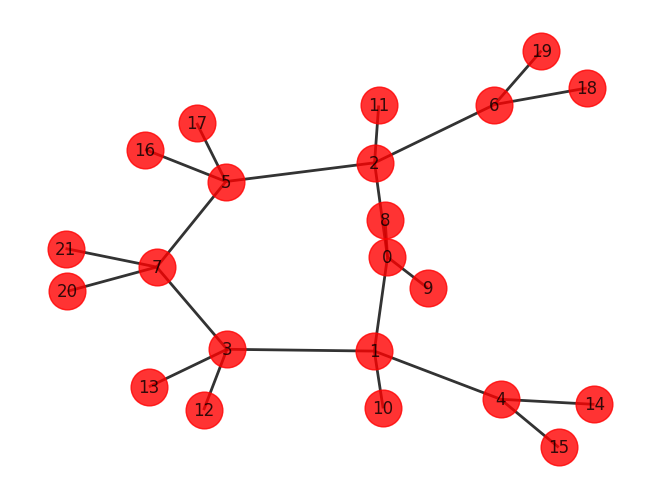

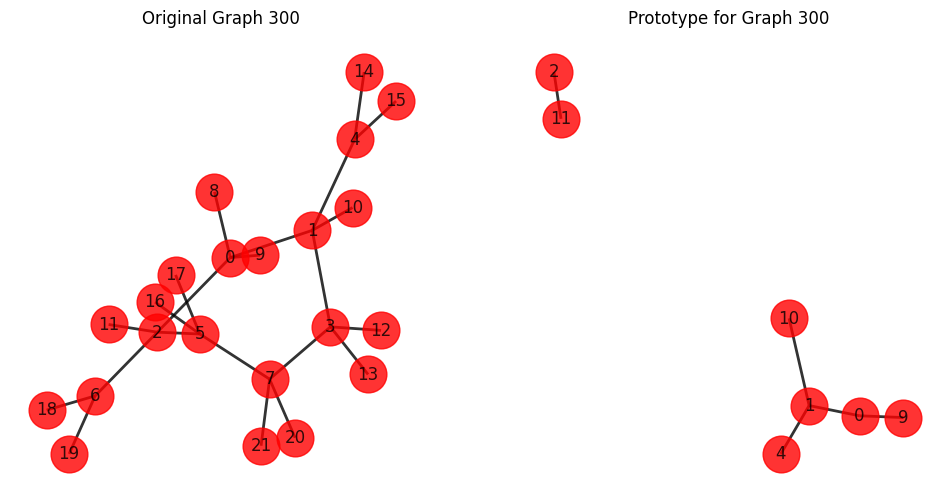

In [48]:
import matplotlib.pyplot as plt
import networkx as nx
from torch_geometric.utils import to_networkx, from_networkx


def explain_and_plot_graph(graph_idx, explainer, threshold=0.9):
    masked_adjs, graphs = explainer.explain_graphs(graph_indices=[graph_idx])

    masked_adj = masked_adjs[0]
    original_G = graphs[0]

    pos = nx.spring_layout(original_G)

    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    nx.draw(
        original_G,
        pos,
        with_labels=True,
        node_color="red",
        edge_color="black",
        width=2,
        node_size=700,
        alpha=0.8,
    )
    plt.title(f"Original Graph {graph_idx}")

    plt.subplot(1, 2, 2)

    prototype_G = io_utils.denoise_graph(
        masked_adj,
        node_idx=0,
        feat=explainer.feat[graph_idx],
        threshold=threshold,
        max_component=False,
    )

    pos = nx.spring_layout(prototype_G)

    nx.draw(
        prototype_G,
        pos,
        with_labels=True,
        node_color="red",
        edge_color="black",
        width=2,
        node_size=700,
        alpha=0.8,
    )
    plt.title(f"Prototype for Graph {graph_idx}")

    plt.show()
    return (original_G, prototype_G)


graph_idx = 300
original_G, prototype_G = explain_and_plot_graph(graph_idx, explainer, 0.2)

In [44]:
# graph_data = [from_networkx(original_G), from_networkx(prototype_G)]

with open("graphs/graph9_star.pkl", "wb") as f:
    pickle.dump((original_G, prototype_G), f)

In [45]:
for node in original_G.nodes:
    if "self" in original_G.nodes[node]:
        del original_G.nodes[node]["self"]
print([original_G.nodes[node] for node in original_G.nodes])

[{'feat': tensor([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       dtype=torch.float64)}, {'feat': tensor([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       dtype=torch.float64)}, {'feat': tensor([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       dtype=torch.float64)}, {'feat': tensor([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       dtype=torch.float64)}, {'feat': tensor([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       dtype=torch.float64)}, {'feat': tensor([0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       dtype=torch.float64)}, {'feat': tensor([0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       dtype=torch.float64)}, {'feat': tensor([0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       dtype=torch.float64)}, {'feat': tensor([0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       dtype=torch.float64)}, {'feat': tensor([0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.